In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_style('white')
import hoag  
import mod_l_exp.utils as mlx
import numpy as np

### GENERATE DATASET

In [2]:
dataset = mlx.generate_multiclass_dataset(n_samples=90000, n_features=1000, n_informative=50, n_redundant=25, n_repeated=0,
                                      n_classes=2, n_clusters_per_class=3,
                                      flip_y=0.1, class_sep=1.0,
                                      random_state=1, hot_encoded=False, partitions_proportions=[1/3, 1/3])

datasets.redivide_data:, computed partitions numbers - [0, 30000, 60000, 90000] len all 90000 DONE


### RESPONSE  FUNCTION for $\alpha$

Setting: we use logistic regression (for binary classification) and optimize regularization hyper-parameter

In [3]:
from sklearn import linear_model

alphas = np.linspace(-0, 20, 50)

def cost_func(a):
    clf = linear_model.LogisticRegression(
        solver='lbfgs',
        C=np.exp(-a), fit_intercept=True, 
        tol=1e-15, max_iter=500)

    clf.fit(dataset.train.data, dataset.train.target)
    cost = linear_model.logistic._logistic_loss(clf.coef_.ravel(), 
                                                dataset.validation.data, dataset.validation.target, 0.)
    print('.', end='')
    return cost

In [4]:
scores = [cost_func(a) for a in alphas]

..................................................

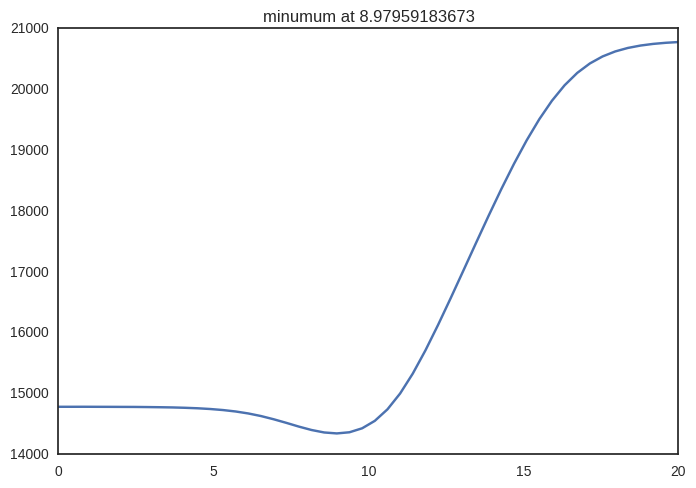

In [5]:
plt.plot(alphas, scores)
plt.title('minumum at ' + str(alphas[np.argmin(scores)]));

### HOAG - NO BOUNDS ON $\alpha$

In [3]:
identity = lambda x: x
clf, res = mlx.hoag_fit(dataset, alpha0=0., projection=identity, max_iter=50)


TypeError: hoag_fit() missing 1 required positional argument: 'datasets'

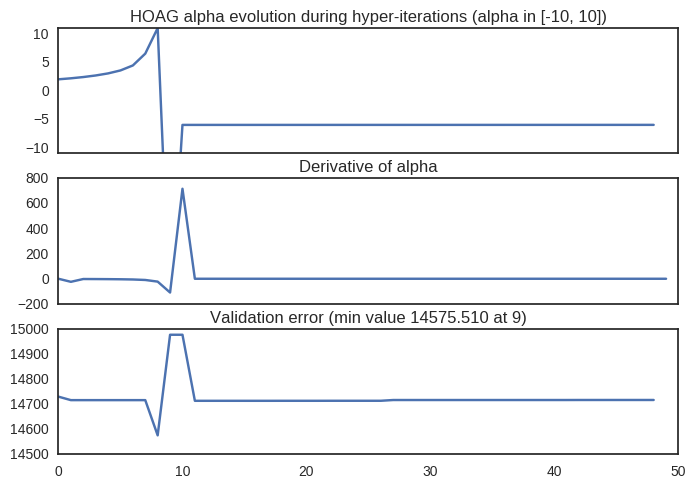

In [13]:
fig, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(res['alpha'][1:])
ax[0].set_ylim(-11, 11)
ax[0].set_title('HOAG alpha evolution during hyper-iterations (alpha in [-10, 10])')
ax[1].plot(res['der alpha'])
ax[1].set_title('Derivative of alpha')

ax[2].set_ylim(14500, 15000)
ax[2].plot(res['validation error'][1:])
ax[2].set_title('Validation error (min value %.3f at %d)' % 
                (np.min(res['validation error']), np.argmin(res['validation error'])))  # the one we're optimizing

In [3]:
from mod_l_exp.rfho_exp import *

Experiment save directory is  /media/luca/DATA/EXPERIMENTS


In [ ]:
saver = rf.Saver(['HOAG comparrison', 'from forked hoag', 'very long'])
res = rtho_experiment(dataset, saver, optimizer_kwargs={'mu': .5, 'lr': 1.e-7}, hyper_iterations=2000,
                hyper_optimizer_class=rf.AdamOptimizer, 
                hyper_optimizer_kwargs={'lr':1.e-2}, 
               hyper_batch_size=10)

folder /media/luca/DATA/EXPERIMENTS/HOAG comparrison/from forked hoag/very long has been created
folder /media/luca/DATA/EXPERIMENTS/HOAG comparrison/from forked hoag/very long/23-06-17__17h43m has been created
settings var names      values
----------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------